In [91]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [92]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [93]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [94]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [95]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [96]:
params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]
evals_result = {}  # 储存评估指标(内置和自定义)结果

model = lgb.train(params=params,
                  train_set=train_dataset,
                  early_stopping_rounds=20,  # 默认early_stopping_rounds=None
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  # This dictionary used to store all evaluation results of all the items in valid_sets.
                  evals_result=evals_result,
                  # Requires at least one validation data.
                  # If True, the eval metric on the valid set is printed at each boosting stage.
                  # If int, the eval metric on the valid set is printed at every verbose_eval boosting stage.
                  # The last boosting stage or the boosting stage found by using early_stopping_rounds is also printed.
                  verbose_eval=200,  # 默认verbose_eval=True
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.0587651	training's MY_GBM_LOSS: 0.0587651	valid_1's multi_logloss: 0.386319	valid_1's MY_GBM_LOSS: 0.386319


array([[5.21326888e-03, 7.99341051e-03, 2.93309518e-01, ...,
        6.57164326e-03, 6.81999324e-01, 1.40583844e-03],
       [2.76179505e-04, 4.50806119e-03, 1.42094240e-04, ...,
        9.94780827e-01, 1.48340858e-04, 7.50685590e-05],
       [9.12244052e-01, 7.89254655e-02, 1.02359799e-03, ...,
        2.50137054e-03, 1.07007699e-03, 3.73075545e-03],
       ...,
       [3.12448622e-03, 4.79071799e-03, 1.83076983e-02, ...,
        3.93860537e-03, 9.21547724e-01, 8.44813790e-04],
       [4.56586230e-01, 5.38676646e-01, 8.58457740e-04, ...,
        2.09934689e-03, 8.98317225e-04, 4.57272184e-04],
       [2.28113451e-04, 3.49762212e-04, 1.54829922e-02, ...,
        2.87550912e-04, 1.77016971e-03, 6.17286721e-05]])

In [97]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 0.05876505136161409),
                          ('MY_GBM_LOSS', 0.05876505136161407)]),
             'valid_1': OrderedDict([('multi_logloss', 0.3863194551290134),
                          ('MY_GBM_LOSS', 0.3863194551290134)])})

In [98]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.3564827779969237,
                1.1620046774038848,
                1.0184359447624614,
                0.900851722466767,
                0.8021494504087373,
                0.7203287848860933,
                0.6516465912546731,
                0.5921062993658119,
                0.5395077815729089,
                0.4940571924155338,
                0.45411705943785113,
                0.4193032990342655,
                0.38747658524207274,
                0.35915298693184244,
                0.3319004911121048,
                0.3082286662335252,
                0.2873505504693532,
                0.26815327113316645,
                0.25100437410046855,
                0.23522967842762763,
                0.22088528930264154,
                0.20798605699239262,
                0.19540569447145287,
                0.1840904980933611,
                0.17383502786716706,
                0.16448751676816512,
          

In [99]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

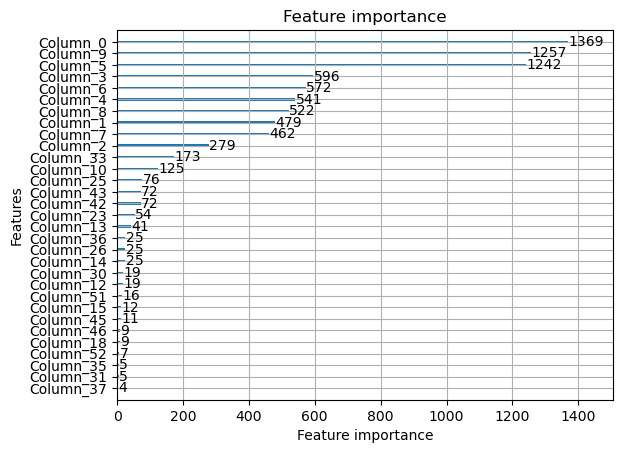

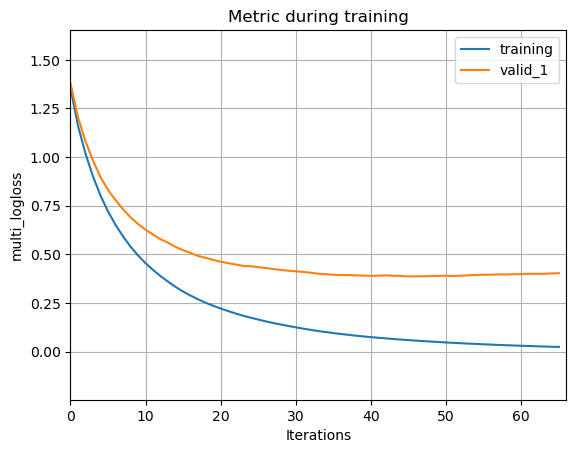

In [100]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

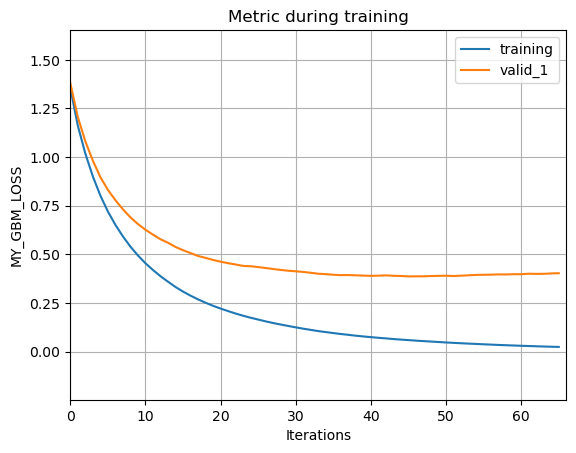

In [101]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [102]:
# 特征的相对重要性
model.feature_importance()

array([1711,  631,  341,  767,  649, 1511,  536,  610,  588, 1302,  119,
          0,   26,    8,   54,   22,    0,    0,    7,    0,    0,    0,
          0,   37,    0,  189,   31,    0,    0,   13,   33,    9,    0,
        153,    0,   10,   41,    3,    0,    0,    0,    0,   60,  114,
          0,    0,   18,    0,    0,    0,    0,    3,    3,    0])

In [103]:
lgb.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

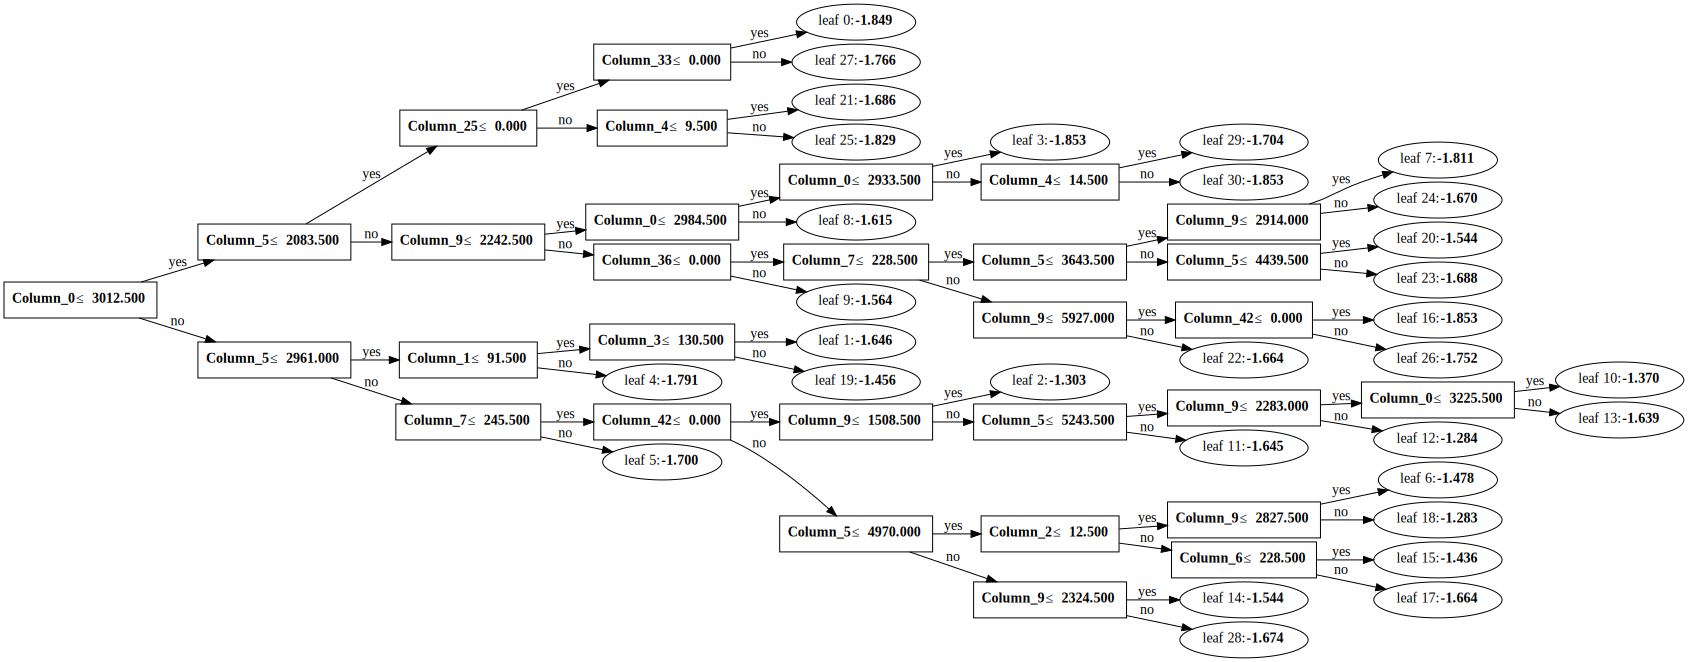

In [104]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [105]:
# 数据类型为graphviz.dot.Digraph
type(img)




graphviz.dot.Digraph